## Realisé par: Adam Bouhnidira 
######                                                                                                                                                                                                           le 28/10/2024

# TP 2 : Convolutional Neural Networks

In [38]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import datasets
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F  
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# 2. Normalize the images between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# 3. Convert NumPy arrays to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)  # Convert images to float tensors
test_images = torch.tensor(test_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long).squeeze()  # Convert labels to long tensors and squeeze for 1D
test_labels = torch.tensor(test_labels, dtype=torch.long).squeeze()

# 4. Change shape from (batch_size, height, width, channels) to (batch_size, channels, height, width)
# Since PyTorch expects (channels, height, width), and CIFAR-10 images are 32x32 RGB (3 channels)
train_images = train_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

# 5. Create DataLoader objects
batch_size = 64
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Third convolutional layer: 64 input channels, 64 output channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # 64 feature maps of size 4x4
        self.fc2 = nn.Linear(64, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten the output of the conv layers
        x = x.view(x.size(0), -1)  # x.size(0) is the batch size, flatten the rest
        
        # Fully connected layers with activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [24]:
def build_and_train(train_loader, optimizer_fn=optim.Adam, epochs=10, learning_rate=0.01):
    # Initialize model, loss function, and optimizer
    model = CNNModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for data, labels in train_loader:
            # No need to flatten the data since the model handles it internally
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            running_loss += loss.item()  # Accumulate the loss

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    return model

In [25]:
trained_model = build_and_train(train_loader, optimizer_fn=optim.Adam, epochs=10, learning_rate=0.001)

Epoch [1/10], Loss: 1.6437
Epoch [2/10], Loss: 1.2579
Epoch [3/10], Loss: 1.1034
Epoch [4/10], Loss: 0.9960
Epoch [5/10], Loss: 0.9205
Epoch [6/10], Loss: 0.8553
Epoch [7/10], Loss: 0.8045
Epoch [8/10], Loss: 0.7578
Epoch [9/10], Loss: 0.7201
Epoch [10/10], Loss: 0.6876


In [29]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()  # Same loss used in training

    with torch.no_grad():  # No need to calculate gradients during evaluation
        total_loss = 0.0
        for data, labels in test_loader:
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            total_loss += loss.item()  # Accumulate loss
            
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)  # Keep track of total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Calculate accuracy
    avg_loss = total_loss / len(test_loader)  # Average loss over the dataset

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate(trained_model, test_loader)


Test Loss: 0.8098, Test Accuracy: 71.98%


# Partie 2

les données sont dans le dossier melanoma cancer dataset

## preproccessing

In [10]:
import os
import pandas as pd

dataset_path = './melanoma_cancer_dataset/train'
csv = 'labels.csv'
labels = ['benign', 'malignant']
data = []

for label in labels:
    label_path = os.path.join(dataset_path, label)
    if os.path.exists(label_path):
        for image_file in os.listdir(label_path):
            if image_file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_path, image_file)
                data.append([image_path, label])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv(csv, index=False)

## data augmentation

In [11]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './melanoma_cancer_dataset/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './melanoma_cancer_dataset/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.


## Création du modéle

In [13]:
import tensorflow as tf

# Model architecture
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

C:\Users\Adam\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## modéle summary

In [14]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,193 (5.98 MB)

 Trainable params: 1,568,193 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

## L'entrainement du modéle (presque 1h 40 min)

In [15]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.6388 - loss: 0.6341 - val_accuracy: 0.7949 - val_loss: 0.4646
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7879 - loss: 0.4748 - val_accuracy: 0.7860 - val_loss: 0.4585
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8197 - loss: 0.4127 - val_accuracy: 0.8490 - val_loss: 0.3795
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.8343 - loss: 0.3858 - val_accuracy: 0.8256 - val_loss: 0.3503
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.8544 - loss: 0.3523 - val_accuracy: 0.8766 - val_loss: 0.2966
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8654 - loss: 0.3362 - val_accuracy: 0.8808 - val_loss: 0.2808
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8625 - loss: 0.3266 - val_accuracy: 0.8542 - val_loss: 0.3402
Epoch 8/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8679 - loss: 0.3187 - val_accu

In [49]:
#on enregistre le modéle pour la reutilisation ou backup etc
model.save('model.keras')

## testing et validation  

In [32]:
dataset_path = './melanoma_cancer_dataset/test'
csv = 'test_labels.csv'
labels = ['benign', 'malignant']
data = []

for label in labels:
    label_path = os.path.join(dataset_path, label)
    if os.path.exists(label_path):
        for image_file in os.listdir(label_path):
            if image_file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_path, image_file)
                data.append([image_path, label])

df = pd.DataFrame(data, columns=['image_path', 'label'])
df.to_csv(csv, index=False)

In [ ]:
test_data = pd.read_csv('test_labels.csv')  

dataset_path = './melanoma_cancer_dataset/test'

results = []
for idx, row in test_data.iterrows():
    img_path = row['image_path']
    true_label = row['label']

    img = image.load_img(img_path, target_size=(180, 180))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    #img_array /= 255.0  # Normalisation # les images ne sont pas normalisé les images avant l entrainements.
    prediction = model.predict(img_array)
    predicted_label = 'malignant' if prediction[0][0] > 0.5 else 'benign'
    results.append([img_path, true_label, prediction[0][0],predicted_label])
results_df = pd.DataFrame(results, columns=['image_path', 'true_label',"prediction_value" ,'predicted_label'])
results_df.to_csv('test_labels.csv', index=False)


## Evaluation

In [36]:
y_true = results_df['true_label'].values
y_pred = results_df['predicted_label'].values
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

#classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[459  41]
 [ 67 433]]
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.92      0.89       500
   malignant       0.91      0.87      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



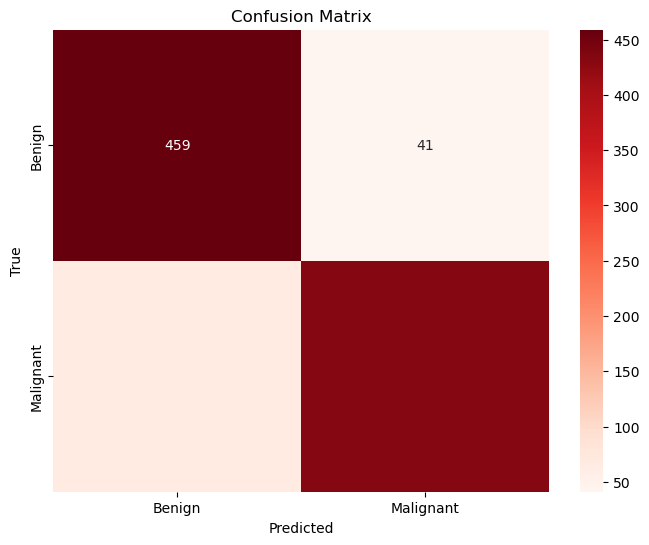

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Accuracy = 0.89